<a href="https://colab.research.google.com/github/FuturisticLover123/InnowiseInternship/blob/main/task1/ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import json
kaggle_token = {"username":"arseniyatrushkevich",
 "key":"546c397b87b27d9af5160bae671e5259"}

json.dump(kaggle_token, open('kaggle.json', 'w'))

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
%pip install kaggle

!mkdir -p data_storage
!kaggle competitions download -c competitive-data-science-predict-future-sales -p data_storage
!unzip -q data_storage/competitive-data-science-predict-future-sales.zip -d data_storage


Note: you may need to restart the kernel to use updated packages.
competitive-data-science-predict-future-sales.zip: Skipping, found more recently modified local copy (use --force to force download)
replace data_storage/item_categories.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
# как можно лучше загружать данные?
# не удобно вот так каждый раз загружать данные

In [4]:
%pip install pandas seaborn matplotlib numpy

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.


In [5]:
path = 'data_storage/'

train = pd.read_csv(f'{path}sales_train.csv')
shops = pd.read_csv(f'{path}shops.csv')
items = pd.read_csv(f'{path}items.csv')
item_categories = pd.read_csv(f'{path}item_categories.csv')
test = pd.read_csv(f'{path}test.csv')

In [6]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
#удаляем отрицательные продажи тк это или ошибки при сборе данных или возвраты товаров
#в любом случае это не то что нам нужно

filtered_train = train[(0 <= train['item_cnt_day'])]

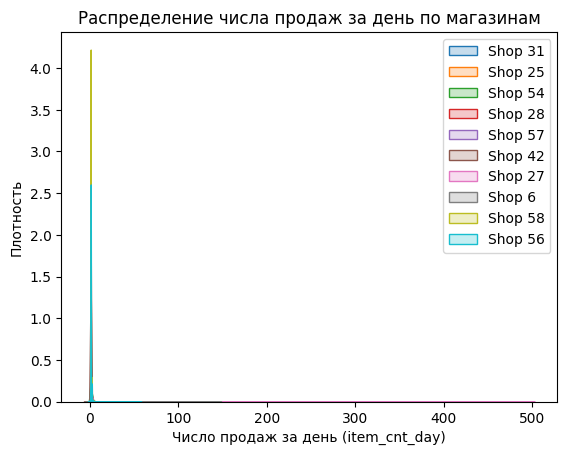

In [8]:
sample_shops = train['shop_id'].value_counts().index[:10]

# у разных магазинов разные пики в распределении продаж
# хочется удалять большие цифры с учетом этого 

for shop in sample_shops:
    sns.kdeplot(data=train[train['shop_id'] == shop], x='item_cnt_day', fill=True, label=f'Shop {shop}')
plt.title('Распределение числа продаж за день по магазинам')
plt.xlabel('Число продаж за день (item_cnt_day)')
plt.ylabel('Плотность')
plt.legend()
plt.show()

In [10]:
def remove_outliers_by_shop(df, column='item_cnt_day'):
    cleaned_dfs = []
    for shop_id in df['shop_id'].unique():
        shop_data = df[df['shop_id'] == shop_id].copy()
        
        if len(shop_data) < 10:
            cleaned_dfs.append(shop_data)
            continue
        
        Q1 = shop_data[column].quantile(0.25)
        Q3 = shop_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        shop_data_cleaned = shop_data[(shop_data[column] >= lower_bound) & 
                                      (shop_data[column] <= upper_bound)]
        
        cleaned_dfs.append(shop_data_cleaned)
    
    return pd.concat(cleaned_dfs, ignore_index=True)

sales_train_cleaned = remove_outliers_by_shop(train, 'item_cnt_day')
print("Размер датасета после удаления выбросов:", sales_train_cleaned.shape)

print("Удалено строк:", len(train) - len(sales_train_cleaned))

# Мы потеряли 10% данных возможно это очень много 

# думаю это так плохо потому что iqr так себе работате с несимметричым распределением + item_cnt_day видимо слишком  случайный
# нужно придумать что-то другое 

Размер датасета после удаления выбросов: (2632181, 6)
Удалено строк: 303668


In [11]:
%pip install scikit-learn
from sklearn.ensemble import IsolationForest  

Note: you may need to restart the kernel to use updated packages.


In [12]:
# пока так

iso_forest = IsolationForest(contamination=0.01, random_state=42)
train['anomaly'] = iso_forest.fit_predict(train[['item_cnt_day']].values)
sales_train_cleaned = train[train['anomaly'] == 1].copy()

In [ ]:
# все продаже за день больше 500 это либо выбросы либо редкие оптовые покупки которые мы все равно предсказать не сможем  
# в целом понимаемо
train[train['item_cnt_day'] > 500].join(items.set_index('item_id'), on='item_id', rsuffix='_item')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,anomaly,item_name,item_category_id
1573253,22.04.2014,15,27,8057,1200.000000,502.0,-1,iTunes 1500 руб.,32
1708207,28.06.2014,17,25,20949,5.000000,501.0,-1,Фирменный пакет майка 1С Интерес белый (34*42)...,71
2048518,02.10.2014,21,12,9242,1500.000000,512.0,-1,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",8
2067669,09.10.2014,21,55,19437,899.000000,508.0,-1,"Средиземье: Тени Мордора [PC, Цифровая версия]",31
2326930,15.01.2015,24,12,20949,4.000000,1000.0,-1,Фирменный пакет майка 1С Интерес белый (34*42)...,71
2608040,14.04.2015,27,12,3731,1904.548077,624.0,-1,"Grand Theft Auto V [PC, русские субтитры]",30
2626181,19.05.2015,28,12,11373,155.192950,539.0,-1,Доставка до пункта выдачи (Boxberry),9
2851073,29.09.2015,32,55,9249,1500.000000,533.0,-1,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8
2851091,30.09.2015,32,55,9249,1702.825746,637.0,-1,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8
2864235,30.09.2015,32,12,9248,1692.526158,669.0,-1,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80


In [68]:
filtered_train = filtered_train[filtered_train['item_price'] <= 10000]

<Axes: xlabel='item_price', ylabel='Density'>

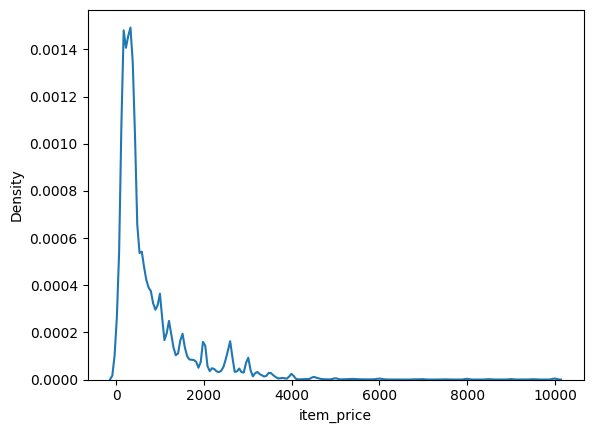

In [ ]:
filtered_train

sns.kdeplot(filtered_train['item_price'])
# стало сильно лучше 

In [13]:
#группировка по месяцами
grouped_train = filtered_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg(item_cnt_month = ('item_cnt_day', 'sum')).reset_index()

In [14]:
grouped_train.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [ ]:
# куда можно все выгрузить?
# не хочется хранить все локально